# PCA空间位置样本优化

In [2]:
# type: ignore
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from scipy.spatial import cKDTree
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [3]:
# type: ignore
def pca_density_downsample(df_category, target_samples, feature_columns, n_components=0.95):
    # Prepare the feature matrix
    X = df_category[['lon', 'lat'] + feature_columns].values
    # 填补缺失值
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Use k-d tree for efficient nearest neighbor search
    tree = cKDTree(X_pca)
    
    # Calculate the distance to the k-th nearest neighbor
    k = min(50, len(X_pca) - 1)  # Use 50 or the maximum possible if less than 50 samples
    distances, _ = tree.query(X_pca, k=k)
    density = 1 / distances[:, -1]  # Use the distance to the k-th neighbor as a proxy for density
    
    # Inverse density sampling
    p = 1.0 / density
    p /= p.sum()
    
    # Sample based on inverse density
    indices = np.random.choice(len(X), size=min(target_samples, len(X)), replace=False, p=p)
    
    return df_category.iloc[indices]

def adaptive_pca_balance(df, feature_columns, target_samples=500, low_threshold=100, high_threshold=1000):
    category_counts = df['NEW_TZ'].value_counts()
    
    resampled_dfs = []
    for category, count in category_counts.items():
        df_category = df[df['NEW_TZ'] == category]
        
        if count < low_threshold:
            # Keep original for low sample categories
            resampled_df = df_category
        elif count > high_threshold:
            # Use PCA-based density downsampling for high sample categories
            target = max(target_samples, int(count * target_samples / high_threshold))
            resampled_df = pca_density_downsample(df_category, target, feature_columns)
        else:
            # For categories between thresholds, adjust sample size proportionally
            target = int(count * target_samples / high_threshold)
            if count > target:
                resampled_df = pca_density_downsample(df_category, target, feature_columns)
            else:
                resampled_df = df_category

        resampled_dfs.append(resampled_df)
    
    final_df = pd.concat(resampled_dfs, ignore_index=True)
    return final_df

def visualize_samples(original_df, balanced_df, n_categories=20):
    # Select top n categories by sample count
    top_categories = original_df['NEW_TZ'].value_counts().nlargest(n_categories).index

    # Prepare data for visualization
    original_counts = original_df['NEW_TZ'].value_counts()
    balanced_counts = balanced_df['NEW_TZ'].value_counts()

    # Create bar plot
    fig, ax = plt.subplots(figsize=(20, 10))
    x = np.arange(len(top_categories))
    width = 0.35

    ax.bar(x - width/2, [original_counts.get(cat, 0) for cat in top_categories], width, label='Original')
    ax.bar(x + width/2, [balanced_counts.get(cat, 0) for cat in top_categories], width, label='Balanced')

    ax.set_ylabel('Sample Count')
    ax.set_title('Sample Count Comparison: Original vs Balanced (Top 20 Categories)')
    ax.set_xticks(x)
    ax.set_xticklabels(top_categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

    # Create scatter plot for spatial distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    scatter1 = ax1.scatter(original_df['lon'], original_df['lat'], c=original_df['NEW_TZ'].astype('category').cat.codes, s=5, alpha=0.5)
    ax1.set_title('Original Data Spatial Distribution')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')

    scatter2 = ax2.scatter(balanced_df['lon'], balanced_df['lat'], c=balanced_df['NEW_TZ'].astype('category').cat.codes, s=5, alpha=0.5)
    ax2.set_title('Balanced Data Spatial Distribution')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')

    plt.tight_layout()
    plt.show()


In [10]:
# Load  data
df = pd.read_csv(r"F:\cache_data\zone_ana\qz\train_data\soil_type_train_point.csv")


In [11]:
df.columns

Index(['point_id', 'longitude', 'latitude', 'TL', 'YL', 'TS', 'TZ', 'label',
       'LON', 'LAT', 'DL', 'DLLB', 'MZMC', 'PW', 'NEW_TZ', 'aspect',
       'carbonate', 'channelnetworkbaselevel', 'channelnetworkdistance',
       'clay_minerals', 'contrast', 'convergenceindex', 'correlation', 'dem',
       'dissimilarity', 'dl', 'entropy', 'etp22_1', 'etp22_10', 'etp22_11',
       'etp22_12', 'etp22_2', 'etp22_3', 'etp22_4', 'etp22_5', 'etp22_6',
       'etp22_7', 'etp22_8', 'etp22_9', 'etp22_mean', 'evi',
       'ferrous_minerals', 'hillshade', 'homogeneity', 'lat', 'lon',
       'lsfactor', 'lswi', 'mean', 'mndwi', 'mrrtf', 'mrvbf', 'ndmi', 'ndvi',
       'ndwi', 'night22_', 'pc1', 'pc2', 'plancurvature', 'pre22_1',
       'pre22_10', 'pre22_11', 'pre22_12', 'pre22_2', 'pre22_3', 'pre22_4',
       'pre22_5', 'pre22_6', 'pre22_7', 'pre22_8', 'pre22_9', 'pre22_mean',
       'profilecurvature', 'relativeslopeposition', 'rock_outcrop', 'savi',
       'secondmoment', 'slope', 'slopepostion', 

Original sample counts:
NEW_TZ
腐中层灰泥质黄壤      2152
中层壤质黄色石灰土     1375
中层灰泥质黄壤       1375
腐中层壤质黄色石灰土     848
腐中层砂质黄色石灰土     710
              ... 
中层砂质灰潮土          2
薄层硅质黄棕壤性土        1
腐薄层硅质黄棕壤         1
薄层砂泥质黄棕壤性土       1
渗鳝泥田             1
Name: count, Length: 92, dtype: int64

Balanced sample counts:
NEW_TZ
腐中层灰泥质黄壤      414
中层灰泥质黄壤       264
中层壤质黄色石灰土     264
腐中层壤质黄色石灰土    163
腐中层砂质黄色石灰土    136
             ... 
中层砂质灰潮土         2
薄层硅质黄棕壤性土       1
腐薄层硅质黄棕壤        1
薄层砂泥质黄棕壤性土      1
渗鳝泥田            1
Name: count, Length: 92, dtype: int64

Total samples before balancing: 14007
Total samples after balancing: 4023


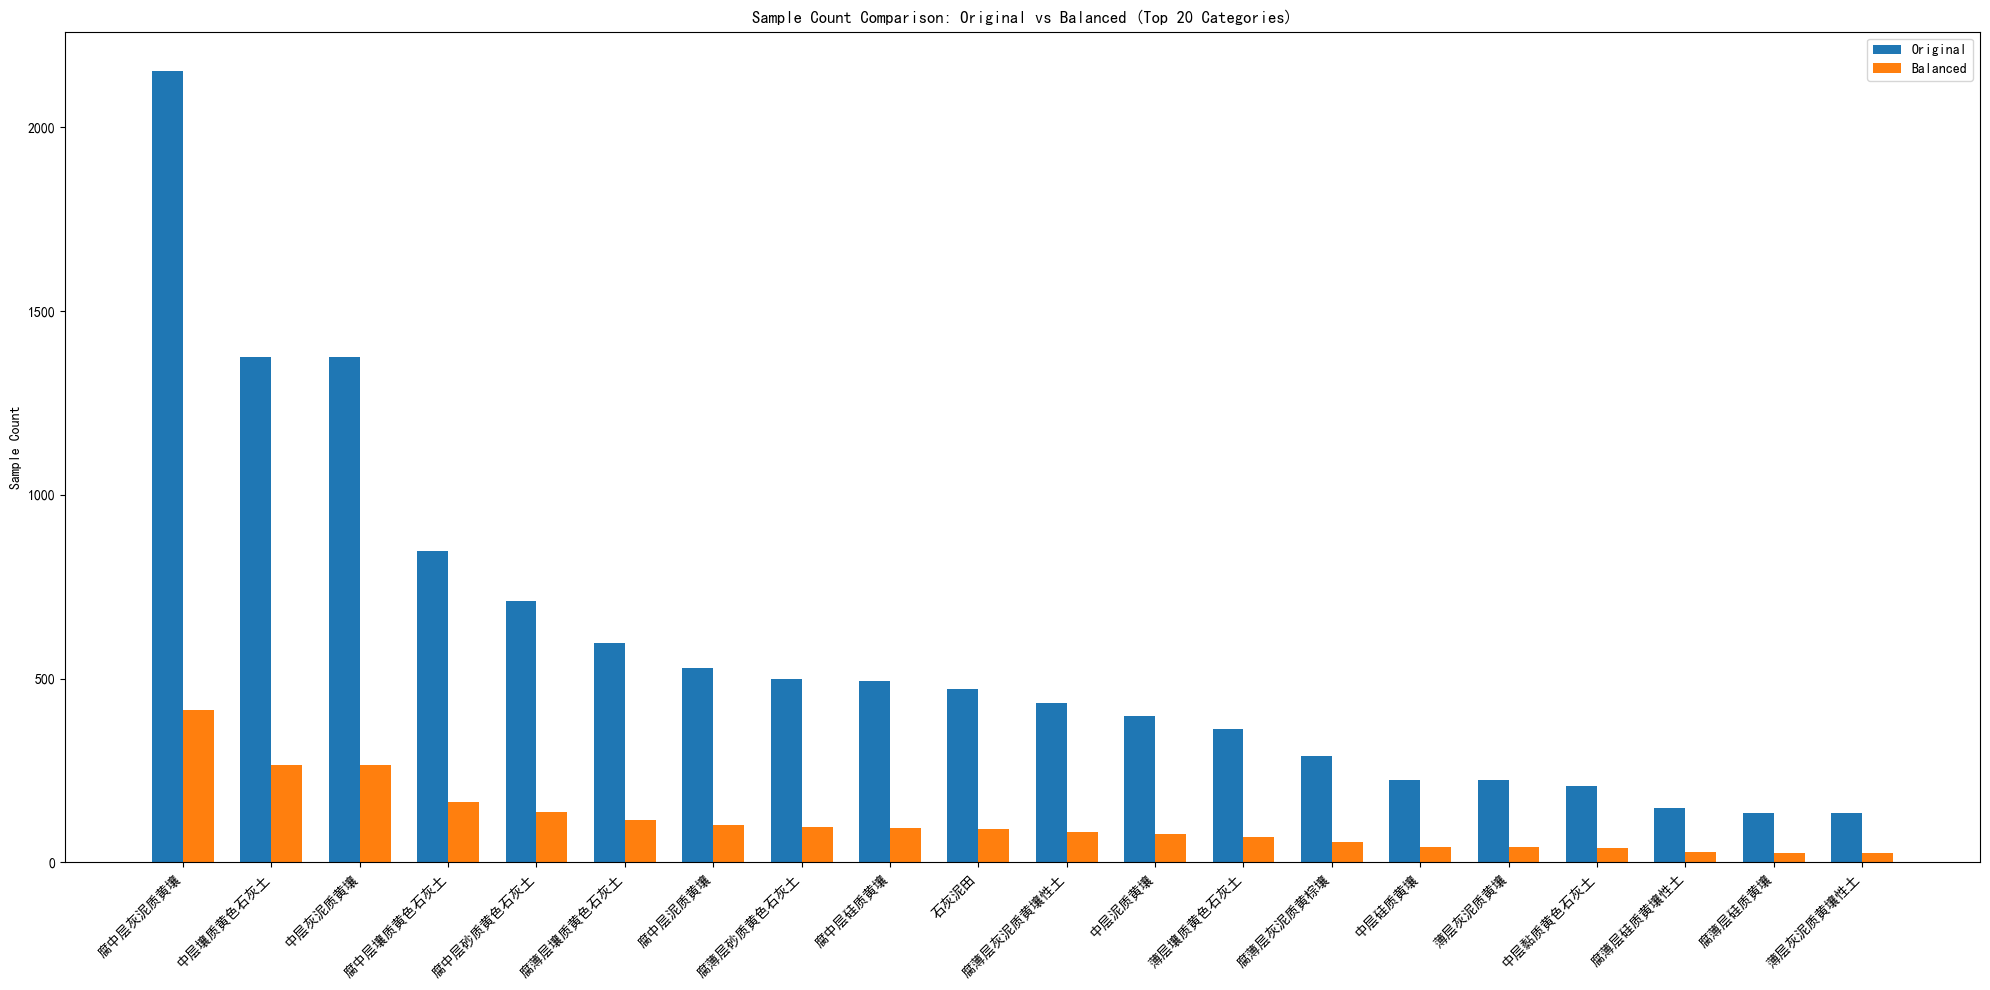

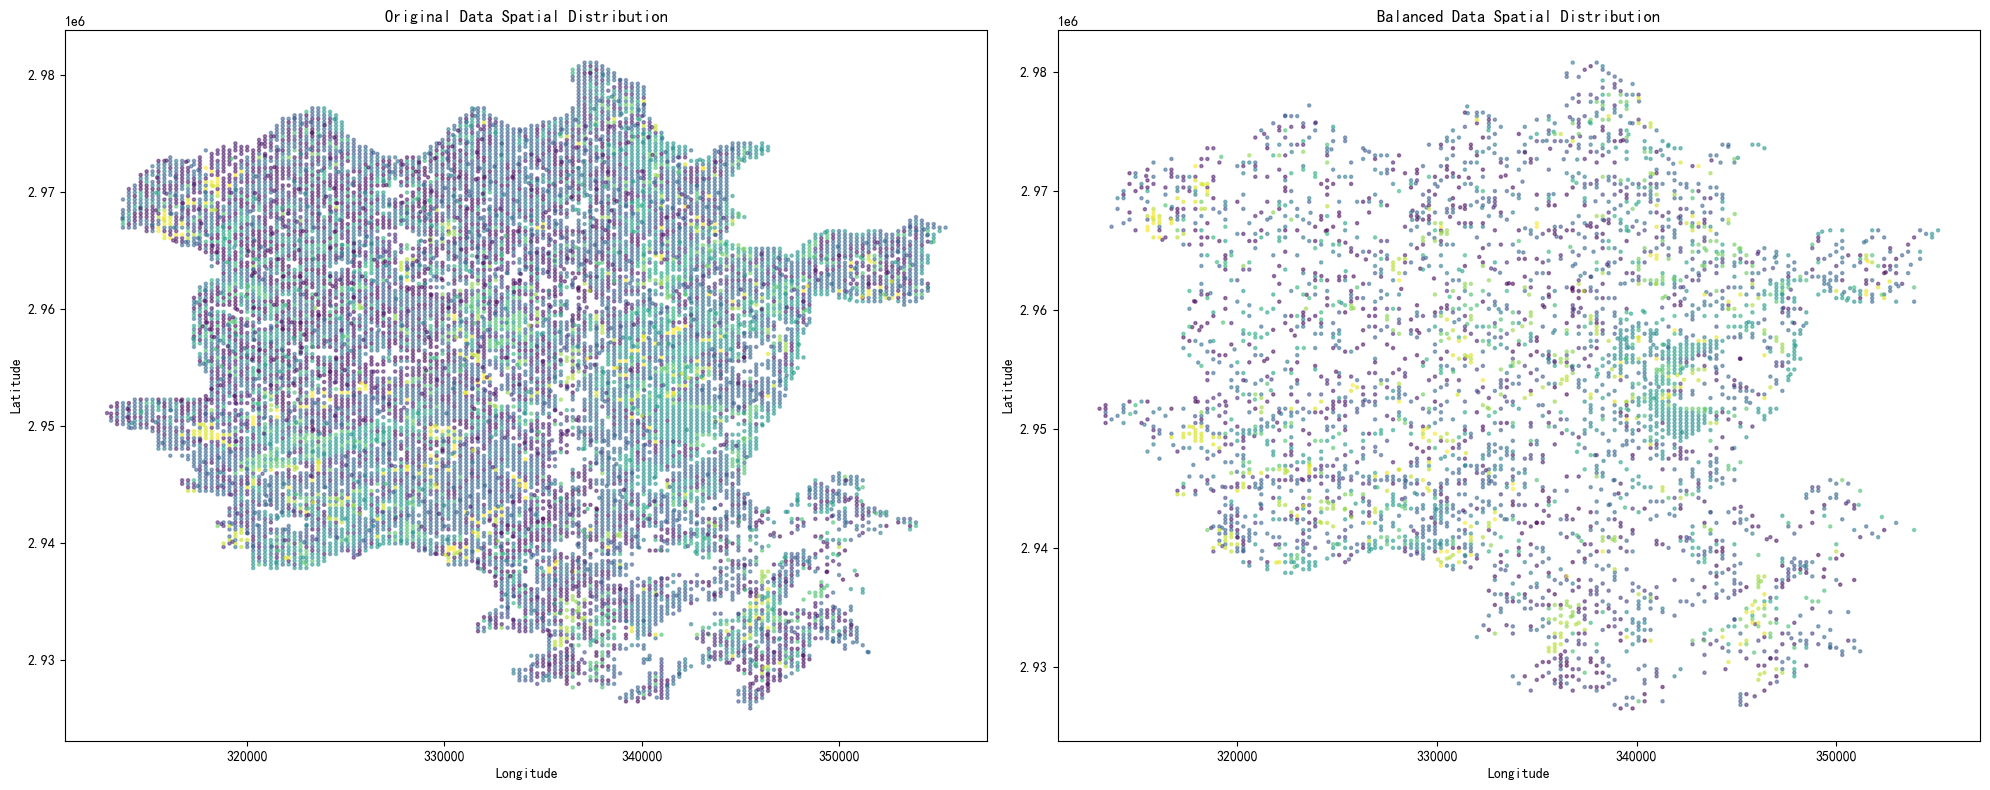

In [6]:
# type: ignore
# 执行分析
# Define the feature columns to consider (excluding 'lon', 'lat', and 'TZ')
feature_columns = ['aspect',
       'carbonate', 'channelnetworkbaselevel', 'channelnetworkdistance',
       'clay_minerals', 'contrast', 'convergenceindex', 'correlation', 'dem',
       'dissimilarity', 'dl', 'entropy', 'etp22_3', 'etp22_mean', 'evi',
       'ferrous_minerals', 'hillshade', 'homogeneity', 'lat', 'lon',
       'lsfactor', 'lswi', 'mean', 'mndwi', 'mrrtf', 'mrvbf', 'ndmi', 'ndvi',
       'ndwi', 'night22_', 'pc1', 'pc2', 'plancurvature', 'pre22_3', 'pre22_mean',
       'profilecurvature', 'relativeslopeposition', 'rock_outcrop', 'savi',
       'secondmoment', 'slope', 'slopepostion', 'terrainruggednessindex',
       'tmp22_3', 'tmp22_mean', 'topographicwetnessindex', 'totalcatchmentarea',
       'valleydepth', 'vari', 'variance']

# Apply the adaptive PCA-based balanced sampling
balanced_df = adaptive_pca_balance(df, feature_columns, target_samples=385, low_threshold=85, high_threshold=2000)

# Display information about the balanced dataset
print("Original sample counts:")
print(df['NEW_TZ'].value_counts())
print("\nBalanced sample counts:")
print(balanced_df['NEW_TZ'].value_counts())
print(f"\nTotal samples before balancing: {len(df)}")
print(f"Total samples after balancing: {len(balanced_df)}")

# Visualize the results
visualize_samples(df, balanced_df)

# Save the balanced dataset to a new CSV file
balanced_df.to_csv(r"F:\cache_data\zone_ana\qz\train_data\pca_balanced_sample_data.csv", index=False)

In [7]:
balanced_df['NEW_TZ'].value_counts().to_dict()


{'腐中层灰泥质黄壤': 414,
 '中层灰泥质黄壤': 264,
 '中层壤质黄色石灰土': 264,
 '腐中层壤质黄色石灰土': 163,
 '腐中层砂质黄色石灰土': 136,
 '腐薄层壤质黄色石灰土': 114,
 '腐中层泥质黄壤': 101,
 '腐薄层砂质黄色石灰土': 95,
 '腐中层硅质黄壤': 94,
 '石灰泥田': 90,
 '腐薄层泥质黄棕壤': 84,
 '腐薄层灰泥质黄壤性土': 83,
 '腐中层暗泥质黄壤': 80,
 '中层壤质灰潮土': 77,
 '中层泥质黄壤': 76,
 '腐厚层泥质黄壤': 71,
 '薄层壤质黄色石灰土': 69,
 '厚层硅质黄壤': 68,
 '中层壤质黑色石灰土': 62,
 '浅石灰泥田': 62,
 '青石灰泥田': 59,
 '腐薄层泥质黄壤': 59,
 '腐薄层泥质黄壤性土': 55,
 '腐薄层灰泥质黄棕壤': 55,
 '腐薄层砂泥质黄棕壤': 53,
 '腐薄层灰泥质黄棕壤性土': 50,
 '轻漂灰泥田': 50,
 '薄层硅质黄壤': 45,
 '青潮泥田': 42,
 '薄层灰泥质黄壤': 42,
 '中层硅质黄壤': 42,
 '黄渗鳝泥田': 41,
 '薄层硅质黄壤性土': 40,
 '中层黏质黄色石灰土': 40,
 '中层灰泥质黄棕壤': 38,
 '黄白粉泥田': 38,
 '黄浅白粉泥田': 35,
 '薄层黏质黄色石灰土': 35,
 '腐薄层黏质黄色石灰土': 34,
 '厚层壤质灰潮土': 33,
 '腐中层壤质灰潮土': 29,
 '腐薄层硅质黄壤性土': 28,
 '腐中层砂泥质黄壤': 28,
 '中层暗泥质黄壤': 26,
 '薄层灰泥质黄壤性土': 25,
 '腐薄层硅质黄壤': 25,
 '腐中层壤质黑色石灰土': 24,
 '腐薄层暗泥质黄棕壤': 24,
 '黄鳝泥田': 21,
 '腐中层黏质黄色石灰土': 21,
 '薄层灰泥质黄棕壤': 20,
 '潮泥田': 20,
 '厚层泥质黄壤': 20,
 '厚层灰泥质黄壤': 19,
 '轻漂鳝泥田': 19,
 '腐薄层砂泥质黄棕壤性土': 19,
 '黄砂泥田': 19,
 '轻漂潮泥田': 18,
 '薄层泥质黄棕壤': 17,
 '腐薄层壤质黑色石灰土': 17,
 '黄浅

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from scipy.spatial import cKDTree
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
class SampleOptimizer:
    def __init__(self, 
                 target_samples=385,
                 low_threshold=85,
                 high_threshold=2000,
                 radius_factor=0.1,
                 outlier_threshold=0.1,
                 feature_importance_threshold=0.01):
        """
        样本优化器初始化
        
        参数:
        target_samples: 每个类别的目标样本数
        low_threshold: 样本数量下限
        high_threshold: 样本数量上限
        radius_factor: 样本生成的搜索半径系数
        outlier_threshold: 异常值检测阈值
        feature_importance_threshold: 特征重要性阈值
        """
        self.target_samples = target_samples
        self.low_threshold = low_threshold
        self.high_threshold = high_threshold
        self.radius_factor = radius_factor
        self.outlier_threshold = outlier_threshold
        self.feature_importance_threshold = feature_importance_threshold
        
    def preprocess_data(self, df, feature_columns):
        """
        数据预处理：清洗、标准化、异常检测
        """
        # 1. 基本清洗
        df_cleaned = df.copy()
        
        # 2. 分别处理经纬度和特征的缺失值
        # 处理经纬度的缺失值
        coords_imputer = SimpleImputer(strategy='median')
        coords = df_cleaned[['lon', 'lat']].values
        coords_imputed = coords_imputer.fit_transform(coords)
        df_cleaned[['lon', 'lat']] = coords_imputed
        
        # 处理特征的缺失值
        features_imputer = SimpleImputer(strategy='median')
        X = df_cleaned[feature_columns].values
        X_imputed = features_imputer.fit_transform(X)
        
        # 3. 标准化
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_imputed)
        
        # 4. 异常值检测和处理
        lof = LocalOutlierFactor(contamination=self.outlier_threshold)
        outlier_labels = lof.fit_predict(X_scaled)
        df_cleaned = df_cleaned[outlier_labels == 1]
        coords_cleaned = df_cleaned[['lon', 'lat']].values
        
        # 5. 空间聚类检测密集区域
        # 确保数据中没有NaN值
        if not np.any(np.isnan(coords_cleaned)):
            dbscan = DBSCAN(eps=0.01, min_samples=5)
            cluster_labels = dbscan.fit_predict(coords_cleaned)
        else:
            # 如果还有NaN，给所有点分配同一个簇
            cluster_labels = np.zeros(len(coords_cleaned))
        
        df_cleaned['cluster'] = cluster_labels
        
        # 6. 更新特征值为处理后的值
        df_cleaned[feature_columns] = X_scaled[outlier_labels == 1]
        
        return df_cleaned
    
    def analyze_feature_importance(self, df, feature_columns):
        """
        分析特征重要性，选择关键特征
        """
        X = df[feature_columns].values
        # 2. 处理缺失值
        imputer = SimpleImputer(strategy='mean')
        X_imputed = imputer.fit_transform(X)    
        pca = PCA()
        pca.fit(StandardScaler().fit_transform(X_imputed))
        
        # 计算特征贡献度
        feature_importance = np.abs(pca.components_[0])
        important_features = [feature_columns[i] 
                            for i in range(len(feature_columns)) 
                            if feature_importance[i] > self.feature_importance_threshold]
        
        return important_features
    
    def generate_similar_samples(self, df_category, feature_columns):
        """
        为样本不足的类别生成新样本，考虑空间约束和特征相似性
        """
        if len(df_category) >= self.target_samples:
            return df_category
                
        # 1. 准备特征矩阵，只使用实际存在的特征列
        available_features = [col for col in feature_columns if col in df_category.columns]
        X = df_category[['lon', 'lat'] + available_features].values
        
        # 确保没有NaN值和异常值
        imputer = SimpleImputer(strategy='median')
        X = imputer.fit_transform(X)
        
        # 使用RobustScaler来处理异常值的影响
        scaler = RobustScaler(quantile_range=(5, 95))
        X_processed = scaler.fit_transform(X)
        
        # 2. 特征降维，添加异常处理
        try:
            # 如果样本数量太少，直接使用原始特征
            if len(X_processed) < 3:
                X_pca = X_processed
            else:
                # 使用更稳定的SVD solver
                pca = PCA(n_components=0.95, svd_solver='full')
                X_pca = pca.fit_transform(X_processed)
                
                # 检查PCA结果是否有效
                if np.any(np.isnan(X_pca)):
                    X_pca = X_processed  # 如果PCA结果无效，使用原始特征
        except Exception:
            X_pca = X_processed  # 如果PCA失败，使用原始特征
        
        # 3. 计算局部密度和搜索半径，添加安全检查
        if len(X_pca) < 2:  # 如果样本太少，使用默认半径
            search_radius = 0.1
        else:
            try:
                nbrs = NearestNeighbors(n_neighbors=min(5, len(X_pca)))
                nbrs.fit(X_pca)
                distances, _ = nbrs.kneighbors(X_pca)
                avg_dist = np.mean(distances[:, 1:])
                if np.isnan(avg_dist) or avg_dist <= 0:
                    search_radius = 0.1
                else:
                    search_radius = min(avg_dist * self.radius_factor, 0.5)  # 进一步限制最大半径
            except Exception:
                search_radius = 0.1
        
        # 4. 生成新样本
        n_samples_to_generate = self.target_samples - len(df_category)
        new_samples = []
        max_attempts = 50
        
        for _ in range(n_samples_to_generate):
            base_idx = np.random.randint(len(X_pca))
            base_sample = X_pca[base_idx]
            
            for attempt in range(max_attempts):
                try:
                    random_direction = np.random.randn(X_pca.shape[1])
                    norm = np.linalg.norm(random_direction)
                    if norm > 0:
                        random_direction /= norm
                    else:
                        continue
                    
                    random_distance = np.random.uniform(0, search_radius)
                    new_sample_pca = (base_sample + random_direction * random_distance).reshape(1, -1)
                    
                    # 如果使用了PCA，需要转换回原始空间
                    if X_pca is not X_processed:
                        new_sample_scaled = pca.inverse_transform(new_sample_pca)
                    else:
                        new_sample_scaled = new_sample_pca
                    
                    new_sample = scaler.inverse_transform(new_sample_scaled)
                    
                    if self._is_valid_sample(new_sample[0], df_category[['lon', 'lat']].values):
                        new_row = {}
                        all_columns = ['lon', 'lat'] + available_features
                        for i, col in enumerate(all_columns):
                            new_row[col] = new_sample[0][i]
                        
                        for col in df_category.columns:
                            if col not in all_columns:
                                new_row[col] = df_category[col].iloc[0]
                        
                        new_samples.append(new_row)
                        break
                except Exception:
                    continue
        
        if new_samples:
            generated_df = pd.DataFrame(new_samples)
            for col in df_category.columns:
                generated_df[col] = generated_df[col].astype(df_category[col].dtype)
            generated_df = generated_df[df_category.columns]
            return pd.concat([df_category, generated_df], ignore_index=True)
        
        return df_category
    
    def _is_valid_sample(self, sample, existing_coords, min_distance=0.001):
        """
        检查生成的样本是否有效
        """
        # 确保sample是一维数组
        sample = np.asarray(sample).ravel()
        
        # 检查坐标是否在合理范围内
        lon, lat = sample[0], sample[1]
        if not (-180 <= lon <= 180 and -90 <= lat <= 90):
            return False
                
        # 检查与现有样本的最小距离
        sample_coord = np.array([[lon, lat]])
        distances = np.min(np.sqrt(np.sum((existing_coords - sample_coord)**2, axis=1)))
        return distances >= min_distance
    
    def balance_samples(self, df, feature_columns):
        """
        样本平衡的主函数
        """
        # 1. 数据预处理
        df_cleaned = self.preprocess_data(df, feature_columns)
        
        # 2. 分析特征重要性
        important_features = self.analyze_feature_importance(df_cleaned, feature_columns)
        
        # 3. 按类别处理样本
        category_counts = df_cleaned['TZ'].value_counts()
        balanced_dfs = []
        
        for category, count in tqdm(category_counts.items(), desc="Processing categories"):
            df_category = df_cleaned[df_cleaned['TZ'] == category]
            
            if count < self.target_samples:
                # 生成新样本
                balanced_df = self.generate_similar_samples(df_category, important_features)
            elif count > self.high_threshold:
                # 降采样
                balanced_df = self.downsample_density(df_category, important_features)
            else:
                balanced_df = df_category
                
            balanced_dfs.append(balanced_df)
            
        # 4. 合并结果
        final_df = pd.concat(balanced_dfs, ignore_index=True)
        
        # 5. 质量控制
        final_df = self.quality_control(final_df, feature_columns)
        
        return final_df
    
    def downsample_density(self, df_category, feature_columns):
        """
        基于密度的降采样
        """
        target = max(self.target_samples, 
                    int(len(df_category) * self.target_samples / self.high_threshold))
        
        X = df_category[['lon', 'lat'] + feature_columns].values
        imputer = SimpleImputer(strategy='mean')
        scaler = RobustScaler()
        X_processed = scaler.fit_transform(imputer.fit_transform(X))
        
        pca = PCA(n_components=0.95)
        X_pca = pca.fit_transform(X_processed)
        
        # 使用KD树计算局部密度
        tree = cKDTree(X_pca)
        k = min(50, len(X_pca) - 1)
        distances, _ = tree.query(X_pca, k=k)
        density = 1 / distances[:, -1]
        
        # 基于密度的反比采样
        p = 1.0 / density
        p /= p.sum()
        
        indices = np.random.choice(len(X), size=target, replace=False, p=p)
        return df_category.iloc[indices]
    
    def quality_control(self, df, feature_columns):
        """
        最终的质量控制
        """
        # 1. 检查并处理特征中的NaN值
        X = df[feature_columns].values
        imputer = SimpleImputer(strategy='median')
        X_imputed = imputer.fit_transform(X)
        
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X_imputed)
        
        # 2. 移除极端异常值
        lof = LocalOutlierFactor(contamination=0.05)
        outlier_labels = lof.fit_predict(X_scaled)
        df = df[outlier_labels == 1]
        
        # 3. 检查空间分布
        coords = df[['lon', 'lat']].values
        if not np.any(np.isnan(coords)):
            dbscan = DBSCAN(eps=0.01, min_samples=3)
            cluster_labels = dbscan.fit_predict(coords)
            df = df[cluster_labels != -1]  # 移除空间离群点
        
        return df
    
    def visualize_results(self, original_df, balanced_df, feature_columns):
        """
        可视化结果
        """
        # 1. 样本数量对比
        plt.figure(figsize=(15, 6))
        plt.subplot(121)
        sns.countplot(data=original_df, x='TZ')
        plt.title('Original Sample Distribution')
        plt.xticks(rotation=45)
        
        plt.subplot(122)
        sns.countplot(data=balanced_df, x='TZ')
        plt.title('Balanced Sample Distribution')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # 2. 空间分布对比
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        scatter1 = ax1.scatter(original_df['lon'], original_df['lat'],
                             c=original_df['TZ'].astype('category').cat.codes,
                             s=5, alpha=0.5)
        ax1.set_title('Original Spatial Distribution')
        
        scatter2 = ax2.scatter(balanced_df['lon'], balanced_df['lat'],
                             c=balanced_df['TZ'].astype('category').cat.codes,
                             s=5, alpha=0.5)
        ax2.set_title('Balanced Spatial Distribution')
        plt.tight_layout()
        plt.show()
        
        # 3. 特征分布对比
        for feature in feature_columns[:5]:  # 展示前5个重要特征
            plt.figure(figsize=(15, 6))
            plt.subplot(121)
            sns.kdeplot(data=original_df, x=feature, hue='TZ')
            plt.title(f'Original {feature} Distribution')
            
            plt.subplot(122)
            sns.kdeplot(data=balanced_df, x=feature, hue='TZ')
            plt.title(f'Balanced {feature} Distribution')
            plt.tight_layout()
            plt.show()



class AutoParameterOptimizer:
    def __init__(self, df, feature_columns):
        """
        初始化自动参数优化器
        
        参数:
        df: 输入的数据框
        feature_columns: 特征列名列表
        """
        self.df = df
        self.feature_columns = feature_columns
        
    def optimize_parameters(self):
        """
        自动优化所有参数
        """
        params = {
            'target_samples': self._optimize_target_samples(),
            'low_threshold': self._optimize_low_threshold(),
            'high_threshold': self._optimize_high_threshold(),
            'radius_factor': self._optimize_radius_factor(),
            'outlier_threshold': self._optimize_outlier_threshold(),
            'feature_importance_threshold': self._optimize_feature_importance_threshold()
        }
        
        return params
        
    def _optimize_target_samples(self):
        """
        优化目标样本数
        基于数据分布和统计特性确定合适的目标样本数
        """
        category_counts = self.df['TZ'].value_counts()
        
        # 计算各种统计指标
        median_count = category_counts.median()
        mean_count = category_counts.mean()
        q1 = category_counts.quantile(0.25)
        q3 = category_counts.quantile(0.75)
        
        # 考虑数据的不平衡程度
        imbalance_ratio = category_counts.max() / category_counts.min()
        
        if imbalance_ratio > 10:
            # 严重不平衡，使用较保守的取值
            target = int(median_count * 0.8)
        else:
            # 相对平衡，使用较激进的取值
            target = int(mean_count * 0.9)
            
        # 确保目标样本数在合理范围内
        min_target = max(30, int(q1 * 0.5))  # 至少30个样本
        max_target = int(q3 * 1.5)  # 不超过Q3的1.5倍
        
        return np.clip(target, min_target, max_target)
    
    def _optimize_low_threshold(self):
        """
        优化低阈值
        基于数据分布确定合适的低阈值
        """
        category_counts = self.df['TZ'].value_counts()
        
        # 用分位数和统计特性
        q1 = category_counts.quantile(0.25)
        min_count = category_counts.min()
        
        # 考虑特征维度
        feature_dim = len(self.feature_columns)
        min_required = max(3 * feature_dim, 30)  # 确保最小样本数足够进行统计分析
        
        # 根据数据分布确定阈值
        low_threshold = max(min_count, min(q1 * 0.5, min_required))
        
        return int(low_threshold)
    
    def _optimize_high_threshold(self):
        """
        优化高阈值
        基于数据分布和计算资源考虑确定合适的高阈值
        """
        category_counts = self.df['TZ'].value_counts()
        
        # 计算统计指标
        q3 = category_counts.quantile(0.75)
        max_count = category_counts.max()
        iqr = category_counts.quantile(0.75) - category_counts.quantile(0.25)
        
        # 使用改进的箱型图方法
        upper_bound = q3 + 1.5 * iqr
        
        # 考虑计算资源和数据规模
        suggested_threshold = min(upper_bound, max_count * 0.8)
        
        return int(suggested_threshold)
    
    def _optimize_radius_factor(self):
        """
        优化半径因子
        基于特征空间的分布确定合适的搜索半径
        """
        # 准备特征数据
        X = self.df[self.feature_columns].values
        # 首先处理缺失值
        imputer = SimpleImputer(strategy='mean')
        X_imputed = imputer.fit_transform(X)
        # 标准化特征
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_imputed)
        
        # 计算近邻统计
        nbrs = NearestNeighbors(n_neighbors=min(5, len(X_scaled)))
        nbrs.fit(X_scaled)
        distances, _ = nbrs.kneighbors(X_scaled)
        
        # 计算平均近邻距离
        avg_dist = np.mean(distances[:, 1:])
        std_dist = np.std(distances[:, 1:])
        
        # 基于距离分布确定半径因子
        radius_factor = avg_dist / (std_dist * 2)
        
        # 限制在合理范围内
        return np.clip(radius_factor, 0.05, 0.3)
    
    def _optimize_outlier_threshold(self):
        """
        优化异常值阈值
        基于数据分布确定合适的异常值检测阈值
        """
        # 计算特征的稳健统计量
        X = self.df[self.feature_columns].values
         # 首先处理缺失值
        imputer = SimpleImputer(strategy='mean')
        X_imputed = imputer.fit_transform(X)
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X_imputed)
        
        # 使用LOF计算局部离群因子
        lof = LocalOutlierFactor(n_neighbors=20)
        lof_scores = -lof.fit_predict(X_scaled)
        
        # 基于LOF分数分布确定阈值
        scores_mean = np.mean(lof_scores)
        scores_std = np.std(lof_scores)
        
        # 使用改进的阈值计算方法
        threshold = min(0.1, 1 / (1 + np.exp(-scores_mean/scores_std)))
        
        return np.clip(threshold, 0.01, 0.15)
    
    def _optimize_feature_importance_threshold(self):
        """
        优化特征重要性阈值
        基于PCA分析确定特征重要性阈值
        """
        # 准备数据
        X = self.df[self.feature_columns].values
        # 首先处理缺失值
        imputer = SimpleImputer(strategy='mean')
        X_imputed = imputer.fit_transform(X)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_imputed)
        
        # 执行PCA
        pca = PCA()
        pca.fit(X_scaled)
        
        # 计算累积方差贡献率
        cumsum = np.cumsum(pca.explained_variance_ratio_)
        
        # 找到解释95%方差所需的成分数
        n_components = np.argmax(cumsum >= 0.95) + 1
        
        # 基于主成分数确定阈值
        threshold = 1 / (n_components * 2)
        
        return np.clip(threshold, 0.01, 0.1)
    
    def suggest_parameters(self):
        """
        提供参数建议并解释原因
        """
        params = self.optimize_parameters()
        
        explanation = {
            'target_samples': {
                'value': params['target_samples'],
                'reason': f"基于类别分布的中位数({self.df['TZ'].value_counts().median():.0f})和均值({self.df['TZ'].value_counts().mean():.0f})确定"
            },
            'low_threshold': {
                'value': params['low_threshold'],
                'reason': f"基于特征维度({len(self.feature_columns)})和数据分布Q1({self.df['TZ'].value_counts().quantile(0.25):.0f})确定"
            },
            'high_threshold': {
                'value': params['high_threshold'],
                'reason': f"基于数据分布Q3({self.df['TZ'].value_counts().quantile(0.75):.0f})和IQR确定"
            },
            'radius_factor': {
                'value': params['radius_factor'],
                'reason': "基于征空间中样本的局部密度分布确定"
            },
            'outlier_threshold': {
                'value': params['outlier_threshold'],
                'reason': "基于局部离群因子(LOF)分数分布确定"
            },
            'feature_importance_threshold': {
                'value': params['feature_importance_threshold'],
                'reason': f"基于PCA分析，保留95%方差信息所需的主成分数确定"
            }
        }
        
        return explanation

def main():
    # 读取数据
    df = pd.read_csv(r"F:\cache_data\zone_ana\qz\train_data\soil_type_train_point.csv")
    # 初步处理缺失值
    for col in df.columns:
        if df[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
            df[col] = df[col].fillna(df[col].median())
    # 添加所有特征
    feature_columns = ['aspect',
       'carbonate', 'channelnetworkbaselevel', 'channelnetworkdistance',
       'clay_minerals', 'contrast', 'convergenceindex', 'correlation', 'dem',
       'dissimilarity', 'dl', 'entropy', 'etp22_3', 'etp22_mean', 'evi',
       'ferrous_minerals', 'hillshade', 'homogeneity', 'lat', 'lon',
       'lsfactor', 'lswi', 'mean', 'mndwi', 'mrrtf', 'mrvbf', 'ndmi', 'ndvi',
       'ndwi', 'night22_', 'pc1', 'pc2', 'plancurvature', 'pre22_3', 'pre22_mean',
       'profilecurvature', 'relativeslopeposition', 'rock_outcrop', 'savi',
       'secondmoment', 'slope', 'slopepostion', 'terrainruggednessindex',
       'tmp22_3', 'tmp22_mean', 'topographicwetnessindex', 'totalcatchmentarea',
       'valleydepth', 'vari', 'variance'] 
    
    # 初始化自动参数优化器
    auto_optimizer = AutoParameterOptimizer(df, feature_columns)
    
    # 获取优化后的参数和解释
    params_with_explanation = auto_optimizer.suggest_parameters()
    
    # 打印参数和解释
    for param_name, info in params_with_explanation.items():
        print(f"\n{param_name}:")
        print(f"建议值: {info['value']}")
        print(f"原因: {info['reason']}")
    
    # 使用优化后的参数初始化SampleOptimizer
    optimizer = SampleOptimizer(
        target_samples=max(params_with_explanation['target_samples']['value'],85),
        low_threshold=min(params_with_explanation['low_threshold']['value'],10),
        high_threshold=params_with_explanation['high_threshold']['value'],
        radius_factor=params_with_explanation['radius_factor']['value'],
        outlier_threshold=params_with_explanation['outlier_threshold']['value'],
        feature_importance_threshold=params_with_explanation['feature_importance_threshold']['value']
    )
    
    # 处理样本
    balanced_df = optimizer.balance_samples(df, feature_columns)
    
    return balanced_df

result_df = main()
result_df.to_csv(r"F:\cache_data\zone_ana\qz\train_data\auto_pca_balanced_sample_data.csv", index=False)


target_samples:
建议值: 30
原因: 基于类别分布的中位数(37)和均值(139)确定

low_threshold:
建议值: 8
原因: 基于特征维度(50)和数据分布Q1(17)确定

high_threshold:
建议值: 242
原因: 基于数据分布Q3(107)和IQR确定

radius_factor:
建议值: 0.3
原因: 基于征空间中样本的局部密度分布确定

outlier_threshold:
建议值: 0.01420012414545936
原因: 基于局部离群因子(LOF)分数分布确定

feature_importance_threshold:
建议值: 0.020833333333333332
原因: 基于PCA分析，保留95%方差信息所需的主成分数确定


Processing categories: 101it [00:04, 21.05it/s]


In [9]:
result_df['TZ'].value_counts().to_dict()


{'紫色大土': 85,
 '板沙田': 85,
 '石卵子土': 85,
 '黄鳝泥田': 85,
 '龙凤大眼泥田': 85,
 '黑泥田': 85,
 '白胶泥土': 85,
 '硅铁质黄棕壤': 84,
 '红沙田': 84,
 '灰沙泥田': 84,
 '白散泥土': 82,
 '红大泥田': 79,
 '白散泥田': 75,
 '紫油沙土': 72,
 '紫色土': 69,
 '血泥土': 68,
 '豆面沙土': 65,
 '浅脚烂泥田': 64,
 '扁沙田': 63,
 '白沙田': 63,
 '白鳝泥田': 62,
 '铝质紫色土': 61,
 '灰砂泥田': 61,
 '深脚烂泥田': 59,
 '灰泡沙土': 58,
 '石沙田': 55,
 '铁质黄棕壤': 54,
 '紫大泥田': 54,
 '死黄泥田': 50,
 '紫泥土': 40,
 '硅质黄棕壤': 35,
 '潮泥田': 31,
 '岩沙土': 29,
 '煤水田': 22,
 '中性紫色土': 19,
 '红大泥土': 17,
 '白大泥田': 17,
 '冷水田': 14,
 '湿鸭屎泥田': 14,
 '寡黄沙泥土': 12,
 '岩灰泡土': 11,
 '黄油沙土': 9,
 '红色石灰土': 8,
 '灰泡黄泥土': 7,
 '黄泥土': 6,
 '潮沙泥田': 6,
 '黄胶泥土': 5,
 '红沙土': 5,
 '冷沙田': 4,
 '死黄泥土': 4,
 '黄灰泡土': 4,
 '灰白胶泥田': 4,
 '石渣子土': 4,
 '磨石沙土': 4,
 '黄油沙田': 3,
 '黄色石灰土': 3,
 '火石沙田': 3,
 '棕色石灰土': 3,
 '铁铝质黄壤性土': 3,
 '硅铁质黄壤': 3,
 '铁铝质黄棕壤': 3,
 '硅铝质黄棕壤': 3,
 '白大泥土': 3,
 '大泥田': 3,
 '黄胶泥田': 3,
 '黄大泥田': 3,
 '次生黄色石灰土': 3,
 '紫沙土': 3,
 '紫红色土': 2,
 '黑色石灰土': 2,
 '扁沙土': 2,
 '豆办沙土': 2,
 '黄沙土': 2,
 '冷沙土': 2,
 '小黄泥田': 2,
 '硅铁质黄壤性土': 2,
 '岩泥': 2,
 '白胶泥田': 2,
 '寡黄泥田': 2,
 '